###### Ключевые задачи исследования:  
1. Изучить воронку продаж. Узнать, как пользователи доходят до покупки.  
2. Исследовать результаты A/A/B-эксперимента. Выяснить какой шрифт лучше

##### План:  
   [Шаг 1. Откроем файл с данными](#a1);  
   [Шаг 2. Изучим и проверим данные](#a2);  
   [Шаг 3. Изучим воронку событий](#a3);  
   [Шаг 4. Изучим результаты эксперимента](#a4).

### <a id='a1'> Шаг 1. Откроем файл с данными,изучим общую информацию, проверим данные </a>

In [5]:
#запустим все необходимые для работы билиотеки
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import scipy.stats as stats
from math import factorial
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
import math as mth
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

In [6]:
#создадим переменную с датафреймом и разделим строки на столбцы
df = pd.read_csv('/content/logs_exp.csv',sep = '\t')

In [8]:
df

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [9]:
#изучим типы данных 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [10]:
#поменяем формат с датой с точностью до секунд
df['EventTimestamp'] = pd.to_datetime(df['EventTimestamp'],unit='s')

In [11]:
#проверим логи на наличие полных дублей
df.duplicated().sum()

413

In [12]:
#удалим дубли
df = df.drop_duplicates()

In [13]:
#рассмотрим кол-во событий в каждой кокретной группе
df['ExpId'].value_counts()

248    85582
246    80181
247    77950
Name: ExpId, dtype: int64

In [14]:
#переименуем столбцы
df = df.rename({'EventName': 'event_name', 'DeviceIDHash': 'device_id','EventTimestamp':'event_time','ExpId':'exp_number'}, axis='columns')

In [15]:
#выделим дату из столбца с временем и датой
df['event_date'] = pd.to_datetime(df['event_time'],format ='%Y-%m-%d').dt.floor('D')

### <a id='a2'> Шаг 2. Изучим и проверим данные </a>

In [16]:
#посчитаем кол-во событий в логе
df.count()

event_name    243713
device_id     243713
event_time    243713
exp_number    243713
event_date    243713
dtype: int64

In [17]:
#посчитаем кол-во событий которые приходятся на одного пользователя
df_id = df.groupby('device_id').agg({'event_time':'count'}).reset_index().sort_values(by = 'event_time',ascending=False)
df_id

,device_id,event_time
5116,6304868067479728361,2307
147,197027893265565660,1998
3714,4623191541214045580,1768
5590,6932517045703054087,1439
1391,1754140665440434215,1221
...,...,...
6013,7399061063341528729,1
2356,2968164493349205501,1
6575,8071397669512236988,1
311,425817683219936619,1


In [18]:
#изучим кол-во событий на одного пользователя
df_id.describe()

,device_id,event_time
count,7.551000e+03,7551.000000
mean,4.677319e+18,32.275593
std,2.655343e+18,65.154219
min,6.888747e+15,1.000000
25%,2.397700e+18,9.000000
50%,4.688022e+18,20.000000
75%,7.007353e+18,37.000000
max,9.222603e+18,2307.000000


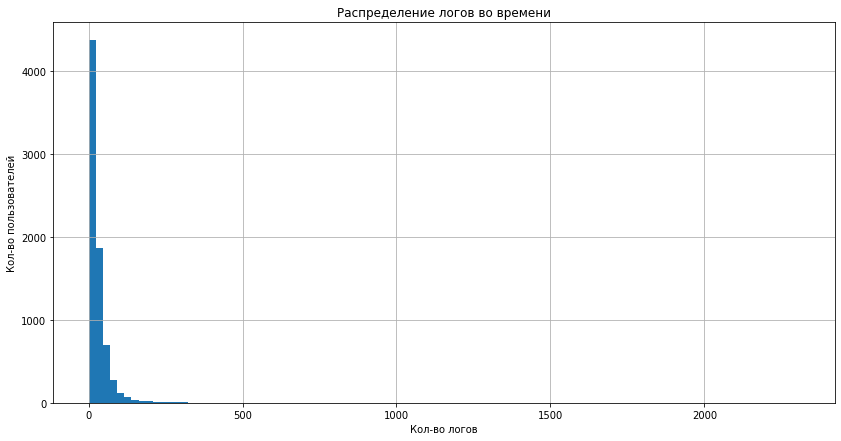

In [19]:
#рассмотрим кол-во событий на одного пользователя в графике
plt.figure(figsize=(14, 7)) 
df_id['event_time'].hist(bins = 100)
plt.title('Распределение логов во времени')
plt.ylabel('Кол-во пользователей') 
plt.xlabel('Кол-во логов')
plt.show()

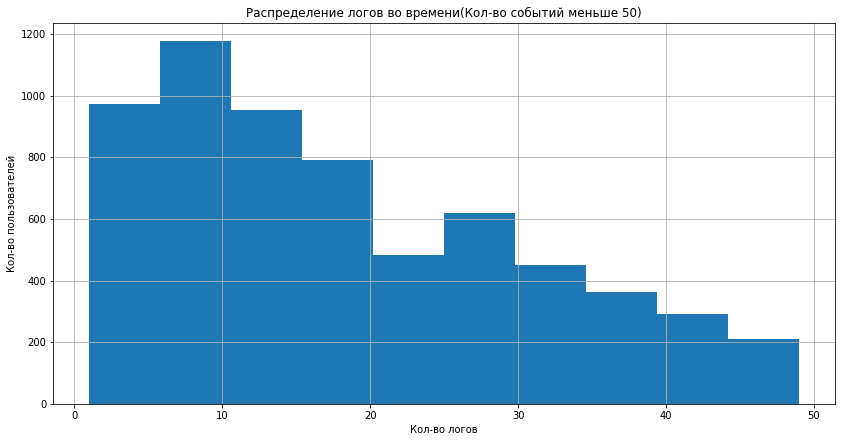

In [20]:
#рассмотрим более детально промежуток гистограммы с самым большим кол-вом событий на пользователя
plt.figure(figsize=(14, 7)) 
df_id.query('event_time < 50')['event_time'].hist()
plt.title('Распределение логов во времени(Кол-во событий меньше 50)')
plt.ylabel('Кол-во пользователей') 
plt.xlabel('Кол-во логов')
plt.show()

In [21]:
#найдем самую ранюю дату, за которую есть данные
df['event_date'].min()

Timestamp('2019-07-25 00:00:00')

In [22]:
#найдем самую позднюю дату, за которую есть данные
df['event_date'].max()

Timestamp('2019-08-07 00:00:00')

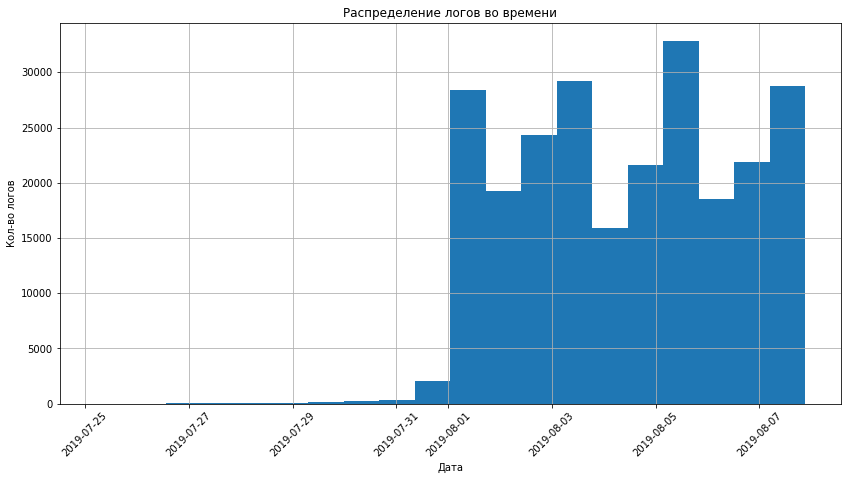

In [23]:
#построим гистограмму по дате и времени событий
plt.figure(figsize=(14, 7)) 
df['event_time'].hist(bins = 20)
plt.title('Распределение логов во времени')
plt.xticks(rotation=45)
plt.ylabel('Кол-во логов') 
plt.xlabel('Дата')
plt.show()

In [24]:
#найдем кол-во событий в день, когда начало поступать чуть больше данных
df.query('event_date == "2019-07-31"')['event_date'].count()

2030

In [25]:
#найдем кол-во зафиксированных событий в первые дни теста до 1 августа 
df.query('event_date <= "2019-07-31"')['event_date'].count()

2826

In [26]:
#перезапищем датасет, убрав даты с неполными данными
df = df.query('event_date >= "2019-08-01"')

In [27]:
#проверим что 1 пользователь попадает только в одну группу, а также, что у нас остались участники всех трех групп после удаления части данных
df_exp = df.pivot_table(index = 'device_id',columns = 'exp_number',values = 'event_name', aggfunc = 'count').reset_index()
df_exp

exp_number,device_id,246,247,248
0,6888746892508752,1.0,NaN,NaN
1,6909561520679493,NaN,5.0,NaN
2,6922444491712477,47.0,NaN,NaN
3,7435777799948366,NaN,NaN,6.0
4,7702139951469979,NaN,137.0,NaN
...,...,...,...,...
7529,9217594193087726423,9.0,NaN,NaN
7530,9219463515465815368,NaN,NaN,17.0
7531,9220879493065341500,6.0,NaN,NaN
7532,9221926045299980007,7.0,NaN,NaN


In [28]:
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7534 entries, 0 to 7533
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   device_id  7534 non-null   int64  
 1   246        2484 non-null   float64
 2   247        2513 non-null   float64
 3   248        2537 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 235.6 KB


In [29]:
#переименуем столбцы, чтобы можно было сделать фильтрацию
df_exp.columns = ['device_id','А1','А2','В']

In [30]:
#заменим пустые значения на 0
df_exp = df_exp.fillna(0)

In [31]:
#выведем на экран только тех пользователей, которые попали в несколько групп 
df_exp.query('А1 != 0 and А2 != 0 and В != 0')

,device_id,А1,А2,В


In [32]:
df_exp.query('А1 == 0 and А2 != 0 and В != 0')

,device_id,А1,А2,В


In [33]:
df_exp.query('А1 != 0 and А2 != 0 and В == 0')

,device_id,А1,А2,В


In [34]:
df_exp.query('А1 != 0 and А2 == 0 and В != 0')

,device_id,А1,А2,В


In [35]:
df['exp_number'].value_counts()

248    84563
246    79302
247    77022
Name: exp_number, dtype: int64

#### Промежуточные выводы:  
    1. Датасет с логами пользователей, участвующих в A-A-B  тесте имеет 243 713 строк;
    2. Уникальных пользователей - 7551;
    3. На одного пользователя в среднем приходится 32 событий, однако их кол-во распределено неравномерно и самое большое кол-во пользователей (почти 1200) совершают около 10 событий, но существуют и те, которые совершили более 2000 зафиксированных событий;
    4. В датасете представлены данные от 25 июля 2019 до 7 августа 2019 года;
    5. До 1 августа 2019 данные почти не поступали (скопилось всего 2826 событий, из которых 2030 за последний день), поэтому в дальнейщем анализе мы будем использовать только период с 1 по 7 августа 2019 года;
    6. В датасете нет пользователей, которые бы попали более чем в 1 группу за период эксперимента.

### <a id='a3'> Шаг 3. Изучим воронку событий</a>

In [36]:
#составим список событий
df['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

In [37]:
#посчитаем сколько раз каждый пользователь совершил то или иное событие
df_e = df.pivot_table(index='event_name',values = 'device_id',aggfunc = 'nunique').sort_values(by='device_id', ascending=False)
df_e = df_e['device_id'].reset_index()

In [38]:
#найдем общее кол-во уникальных пользователей
df.groupby('exp_number')['device_id'].nunique().sum()

7534

In [39]:
#посчитаем долю пользователей, которые хоть раз совершили событие
df_e['share_for_mainscreen'] = df_e['device_id'] / 7419
#посчитаем долю от уникальных пользователей
df_e['share_for_unique'] = df_e['device_id'] / 7551
df_e['delta'] = df_e['share_for_mainscreen']-df_e['share_for_unique']
df_e = df_e.round(3)
df_e

,event_name,device_id,share_for_mainscreen,share_for_unique,delta
0,MainScreenAppear,7419,1.000,0.983,0.017
1,OffersScreenAppear,4593,0.619,0.608,0.011
2,CartScreenAppear,3734,0.503,0.495,0.009
3,PaymentScreenSuccessful,3539,0.477,0.469,0.008
4,Tutorial,840,0.113,0.111,0.002


In [40]:
#оставим только последовательные события 
df_funnel = df_e[['event_name','device_id']].head(4)
df_funnel

,event_name,device_id
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539


In [41]:
fig = go.Figure(
    go.Funnel(
        y=df_funnel['event_name'],
        x=df_funnel['device_id'],
        textinfo = "value+percent previous+percent initial"
    )
)
fig.show() 

#### Промежуточные выводы:  
    1. В тесте мы отслеживаем следующие последовательные события: 'MainScreenAppear'; 'OffersScreenAppear', куда доходит уже 62% пользователей; из них на этап 'CartScreenAppear' переходит 81% пользователей и далее 95% в 'PaymentScreenSuccessful';
    2. Событие Tutorial всего 11% пользователей проходят и оно не является логическим продолжением основной цепочки и может вклиниваться в любой момент времени;
    3. При переходе на этап OffersScreenAppear теряется больше всего пользователей, на него переходит 62% аудитории сайта;
    4. 48% пользователей доходят с этапа MainScreenAppear до PaymentScreenSuccessful;
    5. Проход через все шаги воронки не обязателен, например 1.7% пользователей не заходят на главный экран.

### <a id='a4'> Шаг 4. Изучим результаты эксперимента </a>

In [43]:
#найдем кол-во уникальных пользователей в каждой группе и кол-во пользователей по группам, которые фигурируют в датасете
df_exd = df.pivot_table(index='exp_number',values = 'device_id',aggfunc=['nunique','count']).reset_index()
df_exd.columns = ['nunique','del','count']
df_exd = df_exd[['nunique','count']]
#найдем долю уникалных пользователей
df_exd['share'] = df_exd['nunique']/df_exd['count']
df_exd
#проверим стат.значимость между группами 246 и 247

,nunique,count,share
0,246,79302,0.003102
1,247,77022,0.003207
2,248,84563,0.002933


Нулевая гипотеза - Кол-во пользователей в выборках 246 и 247 статистически не различается  
Альтернативная гипотеза - Кол-во пользователей в выборках 246 и 247 различается.  

In [44]:
all_funnels = df.pivot_table(index='event_name', columns='exp_number',values='device_id',aggfunc='nunique')\
                       .sort_values(246,ascending=False)
all_funnels['246+247'] = all_funnels[246] + all_funnels[247]
all_funnels.drop(['Tutorial'], inplace=True)
all_funnels

exp_number,246,247,248,246+247
event_name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358


In [45]:
users = df.groupby('exp_number')['device_id'].nunique()

In [46]:
users = users.to_frame().reset_index()
users.loc[3] = ['246+247', 4997]

In [47]:
users = users.set_index(users.columns[0])
users

,device_id
exp_number,
246,2484
247,2513
248,2537
246+247,4997


In [48]:
# Воспользуемся Z-критерием
def z_test(exp1, exp2, event, alpha): 
    p1_ev = all_funnels.loc[event, exp1]
    p2_ev = all_funnels.loc[event, exp2] 
    p1_us = users.loc[exp1, 'device_id'] 
    p2_us = users.loc[exp2, 'device_id'] 
    p1 = p1_ev / p1_us 
    p2 = p2_ev / p2_us 
    difference = p1 - p2
    p_combined = (p1_ev + p2_ev) / (p1_us + p2_us) 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / p1_us + 1 / p2_us))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('Проверка для  {} и {}, событие: {}, p-значение: {p_value:.2f}'.format(exp1, exp2, event, p_value=p_value))
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

In [49]:
for event in all_funnels.index:
    z_test(246, 247, event, 0.05)
    print()

Проверка для  246 и 247, событие: MainScreenAppear, p-значение: 0.76
Не получилось отвергнуть нулевую гипотезу

Проверка для  246 и 247, событие: OffersScreenAppear, p-значение: 0.25
Не получилось отвергнуть нулевую гипотезу

Проверка для  246 и 247, событие: CartScreenAppear, p-значение: 0.23
Не получилось отвергнуть нулевую гипотезу

Проверка для  246 и 247, событие: PaymentScreenSuccessful, p-значение: 0.11
Не получилось отвергнуть нулевую гипотезу



In [50]:
for event in all_funnels.index:
    z_test(246, 248, event, 0.05)
    print()

Проверка для  246 и 248, событие: MainScreenAppear, p-значение: 0.29
Не получилось отвергнуть нулевую гипотезу

Проверка для  246 и 248, событие: OffersScreenAppear, p-значение: 0.21
Не получилось отвергнуть нулевую гипотезу

Проверка для  246 и 248, событие: CartScreenAppear, p-значение: 0.08
Не получилось отвергнуть нулевую гипотезу

Проверка для  246 и 248, событие: PaymentScreenSuccessful, p-значение: 0.21
Не получилось отвергнуть нулевую гипотезу



In [51]:
for event in all_funnels.index:
    z_test(247, 248, event, 0.05)
    print()

Проверка для  247 и 248, событие: MainScreenAppear, p-значение: 0.46
Не получилось отвергнуть нулевую гипотезу

Проверка для  247 и 248, событие: OffersScreenAppear, p-значение: 0.92
Не получилось отвергнуть нулевую гипотезу

Проверка для  247 и 248, событие: CartScreenAppear, p-значение: 0.58
Не получилось отвергнуть нулевую гипотезу

Проверка для  247 и 248, событие: PaymentScreenSuccessful, p-значение: 0.74
Не получилось отвергнуть нулевую гипотезу



In [52]:
for event in all_funnels.index:
    z_test('246+247', 248, event, 0.05)
    print()

Проверка для  246+247 и 248, событие: MainScreenAppear, p-значение: 0.29
Не получилось отвергнуть нулевую гипотезу

Проверка для  246+247 и 248, событие: OffersScreenAppear, p-значение: 0.43
Не получилось отвергнуть нулевую гипотезу

Проверка для  246+247 и 248, событие: CartScreenAppear, p-значение: 0.18
Не получилось отвергнуть нулевую гипотезу

Проверка для  246+247 и 248, событие: PaymentScreenSuccessful, p-значение: 0.60
Не получилось отвергнуть нулевую гипотезу



#### Промежуточные выводы:  
    1. Кол-во уникальных пользователей между двумя группами A не одинаково, при этом статистической разницы между ними  как по общим значениям, так и по каждому отдельному событию нет;
    2. Статистической разницы также нет и между каждой группы A c B и с объедененными данными между группами A с B.
P.S. При проверке статестических гипотез использовался уровень значимости в 5%. Все тесты (4 АА и 12 АВ) показали один и тот же результат.

### Общий вывод:  
 В ходе проведения **А-А-В тестов были обнаружены различия** в количестве пользователей в каждой из контрольных групп, а также по этапам их прохождения событий до момента покупки, однако эта разница **статиистически не значима**. То есть изменение шрифта никак не повлияло на поведение пользователей. При этом рекуомендуется продлить проведение эксперимента, так как полные данные есть только за 1 неделю вместо двух.